# now that we have subcortical niftis for all subjects, let's create some masked versions

In [3]:
import os
import nibabel as nb
import numpy as np
out_dir = '/home/shared/2018/visual/hcp_cerebellum/'
import h5py

import matplotlib.pyplot as pl
%matplotlib inline

In [4]:
pkg_dir = '/home/shared/2018/visual/HCP7TFIXED/'


# read prf results for all subjects:
with h5py.File(os.path.join(pkg_dir,'prfresults.mat'), 'r') as mat:
    allresults = mat['/allresults'].value
    
# this is a huge numpy array now, with dimensions:
# 0: run half
#        0 = all data
#        1 = first half of runs
#        2 = second half of runs
# 1: subjects (len = 184)
# 2: prf param (len = 6)
#        0 = polar angle (in degrees from 0-360)
#        1 = ecc
#        2 = size
#        3 = gain
#        4 = r2
#        5 = mean signal
# 3: voxels (len = 91282)


# note: dimensions in niftis:
# 0: angle
# 1: ecc
# 2: gain
# 3: meanvol
# 4: r2
# 5: size

dims = {
    'polar':0,
    'ecc':1,
    'r2':4,
    'size':5,
    'dist':6,
    'instim':7
}

ciftidims = {
    'polar':0,
    'ecc':1,
    'size':2,
    'gain':3,
    'r2':4,
    'mean':5
}

In [5]:
def compute_in_stim_ratio(xs,ys,sigmas):
    """
    computes the ratio of pRF that falls within the stimulus
    aperture
    """
    
    scope = 4 # times the stimated region
    res = 100 # 4*stim_radius * 
    stim_radius = 8
    n = 0.05
    
    from popeye.spinach import generate_og_receptive_fields

    # define visual space in coordinates
    deg_x, deg_y                    =   np.meshgrid(np.linspace(-stim_radius*scope, stim_radius*scope, res), np.linspace(-stim_radius*scope, stim_radius*scope, res)) 

    # create the rfs using the popeye gaussian function
    rfs                             =   generate_og_receptive_fields(xs.astype(float),ys.astype(float),sigmas.astype(float),np.ones(len(xs)).astype(float),deg_x.astype(float),deg_y.astype(float))                                    
    # apply the non linearity
    css_rfs                               =   rfs ** n
    # compute the total pRF content
    total_prf_content               =   css_rfs.reshape((res**2,-1)).sum(axis=0) 
    # and the amount of the pRF inside the stim region
    stim_vignet                        =   np.sqrt(deg_x ** 2 + deg_y**2) < stim_radius                            
    in_stim_ratio                      =   css_rfs[stim_vignet,:].sum(axis=0) / total_prf_content                 
    in_stim_ratio[np.isnan(in_stim_ratio)] = 0

    return in_stim_ratio, css_rfs, stim_vignet

[ 0.99840416  0.08569673]


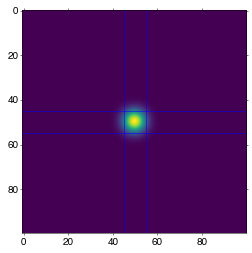

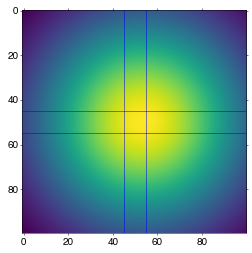

In [6]:
xs = np.array([0,2.5])
ys = np.array([0,0])
sizes = np.array([0.5,5])

rs, rfs,vig = compute_in_stim_ratio(xs,ys,sizes)

print(rs)

pl.imshow(rfs[:,:,0],cmap='viridis')
pl.axhline(100/10*4.5)
pl.axhline(100/10*5.5)
pl.axvline(100/10*4.5)
pl.axvline(100/10*5.5)

pl.figure()
pl.imshow(rfs[:,:,1],cmap='viridis')
pl.axhline(100/10*4.5)
pl.axhline(100/10*5.5)
pl.axvline(100/10*4.5)
pl.axvline(100/10*5.5)

In [7]:
def gmm_threshold(data,n_components=2,maxrange=100):

    from sklearn.mixture import GMM

    # fit gaussian mixture model to define r2 threshold
    gmm = GMM(n_components = n_components)
    gmm = gmm.fit(np.expand_dims(data,1))

    x = np.linspace(0,maxrange,10000)
    logprob, responsibilities = gmm.score_samples(np.expand_dims(x,1))

    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    thresh = x[np.where(pdf_individual[:,0]>pdf_individual[:,1])[0]][0]
    if thresh == 0:
        thresh = x[np.where(pdf_individual[:,1]>pdf_individual[:,0])[0]][0]

    return thresh

In [8]:
def determine_best_subjects(method,n=10):
    
    if method == 'glasser_v123':
        
        '''
        this method looks at explained variance in v123 glasser atlas to determine best subjects
    
        '''
        
        # determine best subjects based on v123
        with h5py.File(os.path.join(out_dir,'atlas.mat'), 'r') as mat:
            v1mask = np.ravel(mat['wang2015'].value==2)
            for roi in [3,4,5,6,7]:
                v1mask += np.ravel(mat['wang2015'].value==roi)

        all_mean_r2 = []
        for sj in range(181):      
            all_mean_r2.append(np.nanmedian(allresults[0,sj,4,v1mask]))

        best_subjects = np.argsort(all_mean_r2)[::-1][:n]

        print 'best subjects based on V123 pRF explained variance: %s'%best_subjects
        
    elif method == 'cerebellum':
        
        '''
        this method looks at explained variance in cerebellum to determine best subjects
    
        '''
        
        # load cerebellum_mask from the cerebellum atlas
        fncer = '/home/vanes/bin/fsl/data/atlases/Cerebellum/Cerebellum-MNIfnirt-maxprob-thr50-2mm.nii.gz'
        cerimg = nb.load(fncer)
        cdata = cerimg.get_data()
        cmask = (cdata!=0)

        # save cmask to check
        cmaskimg=nb.Nifti1Image(cmask,affine=cerimg.affine,header=cerimg.header)
        nb.save(cmaskimg,os.path.join(out_dir,'cmask.nii'))

        all_mean_r2 = []
        for sj in range(181):      

            # load the prf results nifti
            fn = os.path.join(out_dir,'all_subjects','prfresults_subject_%d.dscalar_data_sub.nii'%sj)
            img = nb.load(fn)
            data = img.get_data()

            # mask r2s with cerebellum mask:
            r2s = np.ravel(data[cmask.astype(bool),4])

            all_mean_r2.append(np.nanmedian(r2s))

        best_subjects = np.argsort(all_mean_r2)[::-1][:n]

        print 'best subjects based on cerebellum pRF explained variance: %s'%best_subjects     
        
    elif method == 'cerebellum_gmm':
        
        '''
        this method looks at explained variance in cerebellum to determine best subjects
        In addition to the 'cerebellum' method, this method also separates 'signal' and 'noise' 
        voxel pools by fitting a gaussian mixture model (GMM) to the r2s and only regarding the signal pool
    
        '''
        
        # load cerebellum_mask from the cerebellum atlas
        fncer = '/home/vanes/bin/fsl/data/atlases/Cerebellum/Cerebellum-MNIfnirt-maxprob-thr50-2mm.nii.gz'
        cerimg = nb.load(fncer)
        cdata = cerimg.get_data()
        cmask = (cdata!=0)

        # save cmask to check
        cmaskimg=nb.Nifti1Image(cmask,affine=cerimg.affine,header=cerimg.header)
        nb.save(cmaskimg,os.path.join(out_dir,'cmask.nii'))

        all_mean_r2 = []
        for sj in range(181):      

            # load the prf results nifti
            fn = os.path.join(out_dir,'all_subjects','prfresults_subject_%d.dscalar_data_sub.nii'%sj)
            img = nb.load(fn)
            data = img.get_data()

            # mask r2s with cerebellum mask:
            r2s = np.ravel(data[cmask,dims['r2']])

            thresh = gmm_threshold(r2s,2,100)

            # now combine cerebellum mask with r2 mask
            r2mask = (data[:,:,:,dims['r2']]>thresh)
            mask = r2mask*cmask

            # mask r2s with cerebellum mask:
            r2s = np.ravel(data[mask.astype(bool),dims['r2']])

            all_mean_r2.append(np.nanmedian(r2s))

        best_subjects = np.argsort(all_mean_r2)[::-1][:n]

        print 'best subjects based on signal voxels in cerebellum %s'%best_subjects  
    
    elif method == 'cerebellum_rois':
        '''
        This method looks at the median r2 within the cerebellum ROI determined on data from the average subject.
        '''
        
        # load cerebellum_mask from the cerebellum atlas to get the shape info
        fncer = '/home/vanes/bin/fsl/data/atlases/Cerebellum/Cerebellum-MNIfnirt-maxprob-thr50-2mm.nii.gz'
        cerimg = nb.load(fncer)
        roimask = np.zeros(cerimg.shape)

        # now create roi mask out of selected rois:
        rois = ['left_ventral','right_ventral']#,'left_central','right_central']
        for roi in rois:
            roi_fn = os.path.join(out_dir,roi+'.nii.gz')
            roiimg = nb.load(roi_fn)
            roidata = roiimg.get_data() 
            roimask[roidata==1] = 1

        # save cmask to check
        cmaskimg=nb.Nifti1Image(roimask,affine=cerimg.affine,header=cerimg.header)
        nb.save(cmaskimg,os.path.join(out_dir,'roi.nii'))
        
        all_r2 = []
        for sj in range(181):      

            # load the prf results nifti
            fn = os.path.join(out_dir,'all_subjects','prfresults_subject_%d.dscalar_data_sub.nii'%sj)
            img = nb.load(fn)
            data = img.get_data()

            # mask r2s with roi mask:
            r2s = np.ravel(data[roimask.astype(bool),dims['r2']])    
            all_r2.append(np.nanmedian(r2s))

        best_subjects = np.argsort(all_r2)[::-1][:n]

        print 'best subjects based on median pRF explained variance within cerebellum ROI %s'%best_subjects


    return best_subjects





In [9]:
# best_subjects = determine_best_subjects(method = 'cerebellum_rois')

best_subjects = determine_best_subjects(method = 'cerebellum_rois',n=181)


best subjects based on median pRF explained variance within cerebellum ROI [149  45   7 169 159  25  69  70 156 129 135  50 167  27 141 147 150  98
  47 101  48  56 134  20 116  62 151 109  46 171  77 105  76 125  63 153
  10   3  34  85  58 178  16  72  83 170 179 146 122   5  43 127 113  26
 162 108 140 168  44 100 158 148  37   9  87  36  67  93 177 118 120 137
 111  94  32 175 161   4 138  74  90  12  28 176  84   8  17  35  42  55
  82  14  73  33  99  80 117  39  24   2  75  49 142  38 139 145 112 166
  66  91 102 124  19 128 131 123  23 136  65  78  41  71  96 164  59 110
 172 155  51 115  18 126  31 119 160 163 133  89 132  54 173 154  64   1
  22  81  40  60 114 180  88  57  15   6 121 130 144  13  52  86  30 143
  21  61 107  92  68  11  79 157 103  95  97 106  29 165   0  53 174 152
 104]


# mask voxels in different ways

In [24]:
def mask_voxels(data,mask_type,sj=None):
    """
    This function returns a mask bool where 
    1 = valid voxel
    0 = invalid voxel
    """
    
    if mask_type == 'none':
        
        mask = np.ones_like(data).astype(bool)

    elif mask_type == 'r2':
        
        # determine r2 threshold
        if sj in [181,182,183]:
#             r2thresh=9.8

            r2thresh=9.8

        else:
            r2thresh=2.2
        mask = (data[:,:,:,dims['r2']]>r2thresh)

    elif mask_type == 'r2_ecc':
        
 
        # mask r2s with cerebellum mask:
        if sj in [181,182,183]:
            r2thresh=9.8
        else:
            r2thresh=2.2

        # mask voxels with ecc < 0.5
        eccthresh=0.1   
    
        # define masks
        r2mask = (data[:,:,:,dims['r2']]>r2thresh) # valid voxels
        eccmask = (data[:,:,:,dims['ecc']]>eccthresh) # valid voxels

        # now combine r2 and ecc mask with the spillovermask
        mask = r2mask*eccmask
        
    elif mask_type == 'r2_spill':
        
        # determine r2 threshold
        if sj in [181,182,183]:
            r2thresh=9.8
        else:
            r2thresh=2.2

        r2mask = (data[:,:,:,dims['r2']]>r2thresh) 
        
        # load the spillover mask results nifti
        fn = os.path.join(out_dir,'spillovermask.nii.gz')
        img = nb.load(fn)
        spillmask = img.get_data()
 
        # now combine r2 and ecc mask with the spillovermask
        mask = r2mask*(spillmask==0) # spillovermask is 0 for valid voxels

        
    elif mask_type == 'r2high_spill':
        
        # determine r2 threshold
        if sj in [181,182,183]:
            r2thresh=15
        else:
            r2thresh=2.2

        r2mask = (data[:,:,:,dims['r2']]>r2thresh) 
        
        # load the spillover mask results nifti
        fn = os.path.join(out_dir,'spillovermask.nii.gz')
        img = nb.load(fn)
        spillmask = img.get_data()
 
        # now combine r2 and ecc mask with the spillovermask
        mask = r2mask*(spillmask==0) # spillovermask is 0 for valid voxels
        
    elif mask_type == 'r2_spill_ecc':
        
        # load the spillover mask results nifti
        fn = os.path.join(out_dir,'spillovermask.nii.gz')
        img = nb.load(fn)
        spillmask = img.get_data()
 
        # mask r2s with cerebellum mask:
        if sj in [181,182,183]:
            r2thresh=9.8
        else:
            r2thresh=2.2

        # mask voxels with ecc < 0.5
        eccthresh=0.1   
    
        # define masks
        r2mask = (data[:,:,:,dims['r2']]>r2thresh) # valid voxels
        eccmask = (data[:,:,:,dims['ecc']]>eccthresh) # valid voxels

        # now combine r2 and ecc mask with the spillovermask
        mask = r2mask*eccmask*(spillmask==0) # spillovermask is 0 for valid voxels
        
    elif mask_type == 'r2_spill_size':
        
        # load the spillover mask results nifti
        fn = os.path.join(out_dir,'spillovermask.nii.gz')
        img = nb.load(fn)
        spillmask = img.get_data()
 
        # mask r2s with cerebellum mask:
        if sj in [181,182,183]:
            r2thresh=9.8
        else:
            r2thresh=2.2

        # mask voxels with size > 0.1
        sizethresh=0.15
    
        # define masks
        r2mask = (data[:,:,:,dims['r2']]>r2thresh) # valid voxels
        sizemask = (data[:,:,:,dims['size']]>sizethresh) # valid voxels

        # now combine r2 and ecc mask with the spillovermask
        mask = r2mask*sizemask*(spillmask==0) # spillovermask is 0 for valid voxels
        
    elif mask_type == 'r2_roi':
        
        # load cerebellum_mask from the cerebellum atlas to get the shape info
        fncer = '/home/vanes/bin/fsl/data/atlases/Cerebellum/Cerebellum-MNIfnirt-maxprob-thr50-2mm.nii.gz'
        cerimg = nb.load(fncer)
        roimask = np.zeros(cerimg.shape)
        
        # now create roi mask out of selected rois:
        rois = ['left_ventral','right_ventral']#,'left_central','right_central']
        for roi in rois:
            roi_fn = os.path.join(out_dir,roi+'.nii.gz')
            roiimg = nb.load(roi_fn)
            roidata = roiimg.get_data() 
            roimask[roidata==1] = 1
        roimask = (roimask == 1) # these are the valid voxels
        
        # create r2 mask
        if sj in [181,182,183]:
            r2thresh=9.8
        elif sj == 184:
            r2thrsh = 12.971
        else:
            r2thresh=2.2
        r2mask = (data[:,:,:,dims['r2']]>r2thresh) # valid voxels

        mask = r2mask*roimask
        
    elif mask_type == 'r2_buck':
        
        # load cerebellum_mask from the cerebellum atlas to get the shape info
        fn = os.path.join(out_dir,'buckner_dorsal_att.nii.gz')
        img = nb.load(fn)
        roimask = img.get_data().astype(bool)
        
        # create r2 mask
        if sj in [181,182,183]:
            r2thresh=9.8
        elif sj == 184:
            r2thrsh = 12.971
        else:
            r2thresh=2.2
        r2mask = (data[:,:,:,dims['r2']]>r2thresh) # valid voxels

        mask = r2mask*roimask        
 
    elif mask_type == 'gmmr2_roi':
        
        # load cerebellum_mask from the cerebellum atlas to get the shape info
        fncer = '/home/vanes/bin/fsl/data/atlases/Cerebellum/Cerebellum-MNIfnirt-maxprob-thr50-2mm.nii.gz'
        cerimg = nb.load(fncer)
        roimask = np.zeros(cerimg.shape)
        
        # now create roi mask out of selected rois:
        rois = ['left_ventral','right_ventral']#,'left_central','right_central']
        for roi in rois:
            roi_fn = os.path.join(out_dir,roi+'.nii.gz')
            roiimg = nb.load(roi_fn)
            roidata = roiimg.get_data() 
            roimask[roidata==1] = 1
        roimask = (roimask == 1) # these are the valid voxels
        
        # use r2s from whole brain
        r2s = np.ravel(allresults[0,sj,ciftidims['r2'],:])
        r2thresh = gmm_threshold(r2s)
#         r2thresh = gmm_threshold(np.ravel(data[:,:,:,dims['r2']]))
        print r2thresh
        r2mask = (data[:,:,:,dims['r2']]>r2thresh) # valid voxels

        mask = r2mask*roimask
        
    return mask


### now that we have the best subjects, let's create a 'best_subjects' folder with differently masked niftis in there

Let's do masking as follows:

1. as in paper: r_squared for the avg subjects at 9.8, for the individual subjects at 2.2
2. same r2 mask as in paper, but also include ecc mask > 0.5 dva

In [25]:
best_subjects = determine_best_subjects(method = 'cerebellum_rois',n=181)
order = [np.where(best_subjects==s)[0][0] for s in range(181)]


for sj in [183]:#np.hstack([[183,184],best_subjects]):#np.hstack([range(181),183]):
    
    print('now creating masked niftis for subject %d'%sj)

    if sj == 183:
        mask_types =  ['r2_spill_size']#['r2_spill','r2_spill_ecc']#'r2_ecc']#['r2','r2_spill','r2_spill_ecc','r2high_spill','r2_buck']
        rank = 'avg'
    elif sj == 184:
        rank = 'wavg'
        mask_types = ['r2_roi']#['r2_roi']
    else:
        mask_types = ['r2_roi']#['r2_roi']
        rank = str(np.where(best_subjects==sj)[0][0])
        
    for mask_type in mask_types:
    
        # try to create mask dir
        mask_dir = os.path.join(out_dir,'best_subjects',mask_type)
        if not os.path.isdir(mask_dir): os.mkdir(mask_dir)

        # load the prf results nifti
        fn = os.path.join(out_dir,'all_subjects','prfresults_subject_%s.dscalar_data_sub.nii'%sj)        
        img = nb.load(fn)
        data = img.get_data()

        # determine the mask
        mask = mask_voxels(data,mask_type,sj)
        
        #mask data
        data[~mask] = np.nan

        # save data
        out_fn = os.path.join(mask_dir,'prfresults_subject_rank_%s.nii'%rank)        
        new_data = nb.Nifti1Image(data,affine=img.affine,header=img.header)
        nb.save(new_data,out_fn[:-4])

        # save dimensions separately (for surface plots)
        for m in ['polar','ecc','size','r2','dist','instim']:
            out_fn = os.path.join(mask_dir,'prfresults_subject_rank_%s_%s.nii'%(rank,m))        
            new_data = nb.Nifti1Image(data[:,:,:,dims[m]],affine=img.affine,header=img.header)
            nb.save(new_data,out_fn[:-4])    



best subjects based on median pRF explained variance within cerebellum ROI [149  45   7 169 159  25  69  70 156 129 135  50 167  27 141 147 150  98
  47 101  48  56 134  20 116  62 151 109  46 171  77 105  76 125  63 153
  10   3  34  85  58 178  16  72  83 170 179 146 122   5  43 127 113  26
 162 108 140 168  44 100 158 148  37   9  87  36  67  93 177 118 120 137
 111  94  32 175 161   4 138  74  90  12  28 176  84   8  17  35  42  55
  82  14  73  33  99  80 117  39  24   2  75  49 142  38 139 145 112 166
  66  91 102 124  19 128 131 123  23 136  65  78  41  71  96 164  59 110
 172 155  51 115  18 126  31 119 160 163 133  89 132  54 173 154  64   1
  22  81  40  60 114 180  88  57  15   6 121 130 144  13  52  86  30 143
  21  61 107  92  68  11  79 157 103  95  97 106  29 165   0  53 174 152
 104]
now creating masked niftis for subject 183
